# Introduction

This files contains solutions to the exercises in the notebook `agents-and-environments.ipynb`.

Run the following cell to define load the libraries used in the notebook:

In [57]:
# Numpy: efficient multidimensional arrays
import numpy as np

# matplotlib: interactive plots
import matplotlib.pyplot as plt

# itertools: iterators for efficient looping
import itertools

Let's now define the `MDPEnvironment` class:

In [2]:
class MDPEnvironment(object):

    def __init__(self, tprobs, rewards, init_distr, seed=0):
        self._tprobs = np.array(tprobs, dtype=np.float64)
        self._rewards = np.array(rewards, dtype=np.float64)
        self._init_distr = np.array(init_distr, dtype=np.float64)

        # Check array dimensions
        if self._tprobs.ndim != 3:
            raise ValueError('tprobs must be a 3-dimensional array')
        if self._rewards.ndim != 2:
            raise ValueError('rewards must be a 2-dimensional array')
        if self._init_distr.ndim != 1:
            raise ValueError('init_distr must be a 1-dimensional array')
        if self._tprobs.shape[0] != self._rewards.shape[0]:
            raise ValueError('axis 0 of arrays tprobs and rewards must have the same length')
        if self._tprobs.shape[1] != self._tprobs.shape[2]:
            raise ValueError('axes 1 and 2 of array tprobs must have the same length')
        if self._tprobs.shape[1] != self._rewards.shape[1]:
            raise ValueError('axis 1 of arrays tprobs and rewards must have the same length')
        if self._tprobs.shape[1] != self._init_distr.shape[0]:
            raise ValueError('axis 1 of array tprobs must have the same length as init_distr')

        self._num_actions = self._tprobs.shape[0]
        self._num_states = self._tprobs.shape[1]

        # Define random number generator used to simulate process
        self._rng = np.random.default_rng(seed=seed)

        # Start in an unitialized state
        self._current_state = None
        self._current_reward = None
        self._current_status = 0

    def set_seed(self, seed):
        self._rng = np.random.default_rng(seed=seed)

    def transition_probs(self):
        return self._tprobs.copy()

    def rewards(self):
        return self._rewards.copy()

    def status(self):
        return self._current_status

    def current_state(self):
        return self._current_state

    def current_reward(self):
        return self._current_reward

    def reset(self):
        self._current_status = 1
        self._current_state = self._rng.choice(self._num_states, p=init_distr)
        self._current_reward = 0.0

    def step(self, action):
        if action < 0 or action >= self._tprobs.shape[0]:
            raise ValueError(f'action must be an integer between 0 and {self._tprobs.shape[0]}')
        self._current_reward = self._rewards[action, self._current_state]
        self._current_state = self._rng.choice(self._num_states, p=self._tprobs[action, self._current_state])

The following cell defines the transition probabilities used in the exercises:

In [11]:
# Transition probabilities
tprobs = [
    [
        [2/3, 1/3, 0.0, 0.0],
        [0.0, 2/3, 1/3, 0.0],
        [0.0, 0.0, 2/3, 1/3],
        [1/3, 0.0, 0.0, 2/3]
    ],
    [
        [0.0, 1/2, 0.0, 1/2],
        [1/2, 0.0, 1/2, 0.0],
        [0.0, 1/2, 0.0, 1/2],
        [1/2, 0.0, 1/2, 0.0]
    ]
]

# Rewards
rewards = [
    [40, 30, 20, 10],
    [10, 20, 30, 40]
]

# Exercise 1

An interesting question is whether the average cumulative reward per episode depends on the initial condition. To investigate if this is the case, let's estimate the average reward for each different initial state.

Create a Tiny Robot environment with the same configuration as above, but with a deterministic initial state. For example, to start the environment always in state $0$, use the initial distribution $[1, 0, 0, 0]$. Then, simulate the MDP for $1000$ episodes, with length $50$ for each episode. Print the final average cumulative reward.

Repeat the simulation for each of the other three possible initial states. Determine if the average cumulative rewards depend on the initial state.

In [48]:
rng = np.random.default_rng(seed=42)
seeds = [31, 77, 12, 5]
num_steps = 50
num_episodes = 1000
avg_rewards = np.zeros((4, num_episodes + 1))

for init_state in range(4):
    # Define initial state distribution
    init_distr = np.zeros(4, dtype=np.float64)
    init_distr[init_state] = 1.0

    # Create the Tiny Robot Environment
    tr_env = MDPEnvironment(tprobs, rewards, init_distr, seed=seeds[init_state])

    # Simulate episodes
    for n in range(num_episodes):
        tr_env.reset()
        cumulative_reward = 0.0

        # Simulate one episode
        for t in range(num_steps):
            action = rng.integers(2)
            tr_env.step(action)
            cumulative_reward += tr_env.current_reward()

        # Update average cumulative reward per episode
        prev_reward = avg_rewards[init_state, n]
        avg_rewards[init_state, n + 1] = prev_reward + 1 / (n + 1) * (cumulative_reward - prev_reward)

    print(f'Initial state: {init_state}, average reward per episode: {avg_rewards[init_state, num_episodes]}')

Initial state: 0, average reward per episode: 1246.2800000000002
Initial state: 1, average reward per episode: 1251.4800000000002
Initial state: 2, average reward per episode: 1248.7400000000016
Initial state: 3, average reward per episode: 1251.2999999999981


From these results, it appears that, if there is a dependence of the initial state, it is small.  Notice that initial states 1 and 3, in particular, are very close.

Let's confirm this with a plot:

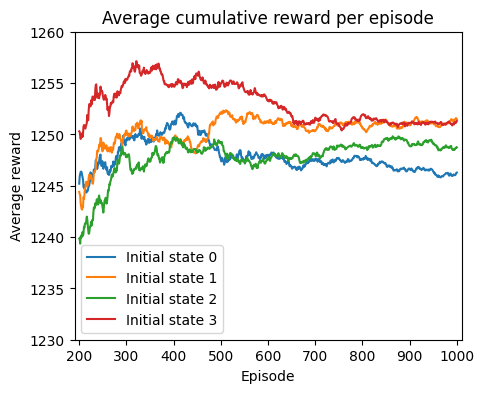

In [49]:
plt.figure(figsize=(5,4))
episodes = range(num_episodes + 1)
start_episode = 200
for init_state in range(4):
    plt.plot(episodes[start_episode:], avg_rewards[init_state, start_episode:], label=f'Initial state {init_state}')
plt.title('Average cumulative reward per episode')
plt.axis([start_episode - 10, avg_rewards.shape[1] + 10, 1230, 1260])
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
None

# Exercise 2

Simulate the process assuming that the robot alternates between actions $0$ and $1$. Run a simulation for 200 episodes of length $50$ and compare the average cumulative reward per episode with the randomized policy we simulated above. Run a separate simulation for each initial state.

In [50]:
rng = np.random.default_rng(seed=42)
seeds = [31, 77, 12, 5]
num_steps = 50
num_episodes = 1000
avg_rewards = np.zeros((4, num_episodes + 1))

for init_state in range(4):
    # Define initial state distribution
    init_distr = np.zeros(4, dtype=np.float64)
    init_distr[init_state] = 1.0

    # Create the Tiny Robot Environment
    tr_env = MDPEnvironment(tprobs, rewards, init_distr, seed=seeds[init_state])

    # Simulate episodes
    for n in range(num_episodes):
        tr_env.reset()
        cumulative_reward = 0.0

        # Simulate one episode
        for t in range(num_steps):
            action = t % 2
            tr_env.step(action)
            cumulative_reward += tr_env.current_reward()

        # Update average cumulative reward per episode
        prev_reward = avg_rewards[init_state, n]
        avg_rewards[init_state, n + 1] = prev_reward + 1 / (n + 1) * (cumulative_reward - prev_reward)

    print(f'Initial state: {init_state}, average reward per episode: {avg_rewards[init_state, num_episodes]}')

Initial state: 0, average reward per episode: 1251.0500000000009
Initial state: 1, average reward per episode: 1253.1399999999987
Initial state: 2, average reward per episode: 1255.0500000000018
Initial state: 3, average reward per episode: 1241.1899999999996


In this case, it seems that there is a larger dependence on the initial state.

Let's see the graph:

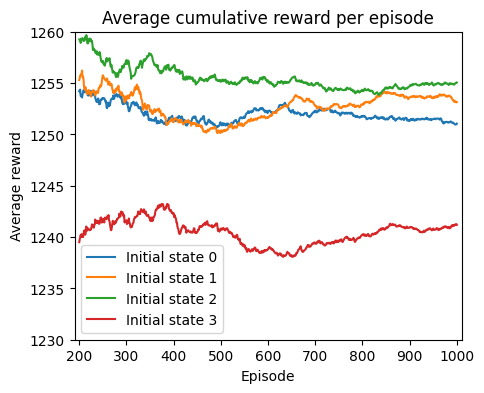

In [51]:
plt.figure(figsize=(5,4))
episodes = range(num_episodes + 1)
start_episode = 200
for init_state in range(4):
    plt.plot(episodes[start_episode:], avg_rewards[init_state, start_episode:], label=f'Initial state {init_state}')
plt.title('Average cumulative reward per episode')
plt.axis([start_episode - 10, avg_rewards.shape[1] + 10, 1230, 1260])
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
None

# Exercise 3

Now suppose the robot chooses action $0$ when in states $0$ and $2$, and action $1$ when in states $1$ and $3$. Run a simulation as in the previous exercises to estimate the average cumulative reward per episode for all possible initial states.

In [53]:
rng = np.random.default_rng(seed=42)
seeds = [31, 77, 12, 5]
num_steps = 50
num_episodes = 1000
avg_rewards = np.zeros((4, num_episodes + 1))

for init_state in range(4):
    # Define initial state distribution
    init_distr = np.zeros(4, dtype=np.float64)
    init_distr[init_state] = 1.0

    # Create the Tiny Robot Environment
    tr_env = MDPEnvironment(tprobs, rewards, init_distr, seed=seeds[init_state])

    # Simulate episodes
    for n in range(num_episodes):
        tr_env.reset()
        cumulative_reward = 0.0

        # Simulate one episode
        for t in range(num_steps):
            current_state = tr_env.current_state()
            if current_state == 0 or current_state == 2:
                action = 0
            else:
                action = 1
            tr_env.step(action)
            cumulative_reward += tr_env.current_reward()

        # Update average cumulative reward per episode
        prev_reward = avg_rewards[init_state, n]
        avg_rewards[init_state, n + 1] = prev_reward + 1 / (n + 1) * (cumulative_reward - prev_reward)

    print(f'Initial state: {init_state}, '
          f'average reward per episode: {avg_rewards[init_state, num_episodes]}')

Initial state: 0, average reward per episode: 1517.500000000001
Initial state: 1, average reward per episode: 1492.6800000000012
Initial state: 2, average reward per episode: 1473.9200000000012
Initial state: 3, average reward per episode: 1512.1799999999998


In this example, the dependence on the initial state is more marked. Also notice that the rewards are larger than in the previous exercises.

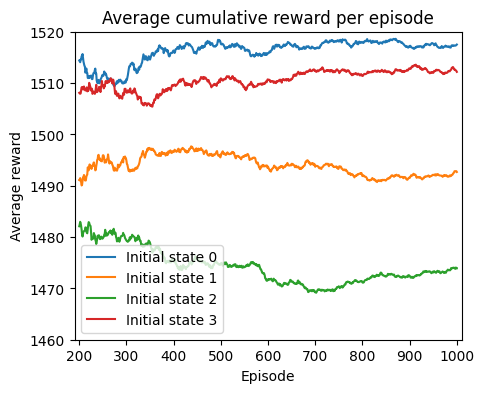

In [56]:
plt.figure(figsize=(5,4))
episodes = range(num_episodes + 1)
start_episode = 200
for init_state in range(4):
    plt.plot(episodes[start_episode:], avg_rewards[init_state, start_episode:], label=f'Initial state {init_state}')
plt.title('Average cumulative reward per episode')
plt.axis([start_episode - 10, avg_rewards.shape[1] + 10, 1460, 1520])
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
None

# Exercise 4

Can you find a choice of actions that performs better than the choices in exercises 1 to 3? How could you sistematically search for the best possible way to choose the actions?

One possibility is to suppose chooses an action depending on the state it is currently in. There are $4$ states and $2$ actions, so the total number of possibilites is $2^4=16$.

In the cell below, we run $1000$ episodes of length $50$ for each choice of actions, computing the average cumulative reward for all initial states in each case.

In [63]:
rng = np.random.default_rng(seed=42)
seeds = [31, 77, 12, 5]
num_steps = 50
num_episodes = 1000

print('Average cumulative rewards')
print('Each row is an action choice')
print('Each column represents a different initial state')

for action_choices in itertools.product([0, 1], repeat=4):
    print(f'{action_choices}', end=' ')
    for init_state in range(4):
        # Define initial state distribution
        init_distr = np.zeros(4, dtype=np.float64)
        init_distr[init_state] = 1.0

        # Create the Tiny Robot Environment
        tr_env = MDPEnvironment(tprobs, rewards, init_distr, seed=seeds[init_state])

        avg_reward = 0.0
        # Simulate episodes
        for n in range(num_episodes):
            tr_env.reset()
            cumulative_reward = 0.0

            # Simulate one episode
            for t in range(num_steps):
                current_state = tr_env.current_state()
                action = action_choices[current_state]
                tr_env.step(action)
                cumulative_reward += tr_env.current_reward()

            avg_reward += 1 / (n + 1) * (cumulative_reward - avg_reward)
        print(f'{avg_reward:7.2f}', end=' ')
    print()

Average cumulative rewards
Each row is an action choice
Each column represents a different initial state
(0, 0, 0, 0) 1286.86 1237.04 1219.34 1251.13 
(0, 0, 0, 1) 1485.63 1452.50 1448.67 1480.02 
(0, 0, 1, 0) 1422.17 1386.93 1379.01 1376.90 
(0, 0, 1, 1) 1655.57 1630.24 1637.07 1653.85 
(0, 1, 0, 0) 1350.25 1312.15 1275.55 1308.32 
(0, 1, 0, 1) 1517.50 1492.68 1473.92 1512.18 
(0, 1, 1, 0) 1491.96 1461.35 1444.62 1439.43 
(0, 1, 1, 1) 1672.84 1651.94 1657.39 1675.31 
(1, 0, 0, 0)  819.63  855.70  814.61  810.09 
(1, 0, 0, 1) 1243.32 1260.18 1242.88 1258.54 
(1, 0, 1, 0)  986.92 1041.70 1007.90  968.42 
(1, 0, 1, 1) 1482.00 1500.91 1501.07 1501.50 
(1, 1, 0, 0)  636.56  654.31  652.21  632.11 
(1, 1, 0, 1) 1154.94 1156.50 1168.89 1175.01 
(1, 1, 1, 0)  664.10  686.29  684.12  660.34 
(1, 1, 1, 1) 1240.38 1239.08 1261.78 1257.76 


From the output above, we see that the best choice of actions is to choose action $0$ when in state $0$ and action $1$ in all other states. The average cumulative rewards for each initial states are:

| Initial state | Average reward |
|:-------------:|:--------------:|
|0              |1672.84         |
|1              |1651.94         |
|2              |1657.39         |
|3              |1675.31         |

# Exercise 5

How can we be sure that the number of episodes simulated is large enough to give a good estimate for the average cumulative reward? One way to assess this is to compute a *confidence interval*, as in the outline below:

- Modify the code so that, instead of storing the average reward, it records the cumulative rewards for each episode in a Numpy array `cumulative_rewards`.

- Compute the average $\mu$ and standard deviation $\sigma$ of the array of cumulative rewards. This can be done with the functions `np.mean()` and `np.std_dev()`

- The 95% confidence interval is given by the formula:
$$
\left(\mu-1.96\frac{\sigma}{\sqrt{N_\text{episodes}}}, \mu+1.96\frac{\sigma}{\sqrt{N_\text{episodes}}}\right),
$$

Write code to find confidence intervals for the average cumulative reward based on simulations. Use the best choice of actions you obtained in the previous exercise, and consider all possible initial states.

In [68]:
rng = np.random.default_rng(seed=42)
seeds = [31, 77, 12, 5]
num_steps = 50
num_episodes = 1000
action_choices = [0, 1, 1, 1]
for init_state in range(4):
    # Define initial state distribution
    init_distr = np.zeros(4, dtype=np.float64)
    init_distr[init_state] = 1.0

    # Create the Tiny Robot Environment
    tr_env = MDPEnvironment(tprobs, rewards, init_distr, seed=seeds[init_state])

    cumulative_rewards = []
    # Simulate episodes
    for n in range(num_episodes):
        tr_env.reset()
        cumulative_reward = 0.0

        # Simulate one episode
        for t in range(num_steps):
            current_state = tr_env.current_state()
            action = action_choices[current_state]
            tr_env.step(action)
            cumulative_reward += tr_env.current_reward()

        cumulative_rewards.append(cumulative_reward)

    # Compute confidence interval
    mu = np.mean(cumulative_rewards)
    sigma = np.std(cumulative_rewards)
    margin_of_error = 1.96 * sigma / np.sqrt(num_episodes)
    lower_bound = mu - margin_of_error
    upper_bound = mu + margin_of_error
    print(f'Initial state: {init_state}, average reward: {mu:6.2f}, ',
          f'ME: {margin_of_error:5.2f}, '
          f'CI: ({lower_bound:6.2f}, {upper_bound:6.2f})')

Initial state: 0, average reward: 1672.84,  ME:  3.80, CI: (1669.04, 1676.64)
Initial state: 1, average reward: 1651.94,  ME:  3.70, CI: (1648.24, 1655.64)
Initial state: 2, average reward: 1657.39,  ME:  3.70, CI: (1653.69, 1661.09)
Initial state: 3, average reward: 1675.31,  ME:  3.73, CI: (1671.58, 1679.04)
